In [4]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from Data_Processing import reduce_memory_usage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

## Hyper parameter tuning LSTM Encoder/Decoder Model with 10 Step Prediction

### Pre Processing & Dataset Preparation

#### GPU use
Emply GPU to accelerate the training of the deep learning model.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load and Clean Data

Data is stored in csv files. We will only consider traces where Csv_breath_hold and Data_breath_hold differs by fewer than 2 seconds

In [6]:
breath_df = pd.read_pickle('breath_df')
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

#### Memory Usage 

In [7]:
under2 = reduce_memory_usage(under2)

Mem. usage decreased to  0.20 Mb from  0.26 Mb (21.4% reduction)


In [8]:
df = breath_df

In [9]:
df.shape

(5710, 6)

#### Split Data

In [10]:
train_size = int((len(df)) * 0.70)
valid_size = int((len(df))*.20)
test_size = int((len(df))*.10)
print("train size is:",train_size)
print("validation size is:",valid_size)
print("test size is:",test_size)

train size is: 3996
validation size is: 1142
test size is: 571


In [11]:
train = df.iloc[0:train_size,:]
valid = df.iloc[train_size:train_size+valid_size,:]
test = df.iloc[train_size+valid_size:, :]
print("train data shape is:",train.shape)
print("validation data shape is:",valid.shape)
print("test data shape is:",test.shape)

train data shape is: (3996, 6)
validation data shape is: (1142, 6)
test data shape is: (572, 6)


In [12]:
train.head(2)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.4727, 0.4687, 0.4646, 0.4605, 0.4563, 0.452...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"


In [14]:
len(train.iloc[0]['Trace'])

1500

#### Resample Data

In [35]:
X_train = [row[::5] for row in train['Trace']]
X_val = [row[::5] for row in valid['Trace']]
X_test = [row[::5] for row in test['Trace']]

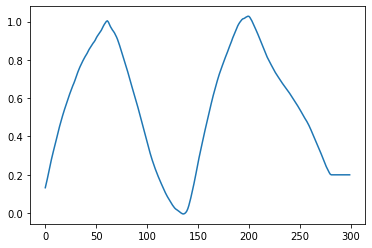

In [137]:
plt.plot(X_train[0])

#### Normalize Data

In [40]:
scaler = MinMaxScaler((-1,1))
# Fit
scaler.fit(list(X_train))
# Transform
x_train = scaler.transform(list(X_train))
x_val = scaler.transform(list(X_val))
x_test = scaler.transform(list(X_test))

#### Sliding Window

We wil use a sliding window of 100 points.
Our target(labels) is 10 points

In [41]:
num_outputs = 10

In [42]:
Train = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=x_train)
Valid = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=x_val)
Test = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=x_test)

#### Define Dataset

Convert data to tensors

In [43]:
def reshape_series(series):
    series = np.transpose(np.array(series))
    return series.reshape(series.shape[0],series.shape[1], 1)

x_train = reshape_series(list(Train['Trace']))
x_val = reshape_series(list(Valid['Trace']))
x_test = reshape_series(list(Test['Trace']))
y_train = reshape_series(list(Train['Next_pts']))
y_val = reshape_series(list(Train['Next_pts']))
y_test = reshape_series(list(Test['Next_pts']))

In [44]:
#dataset
from torch.utils.data import Dataset

In [45]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [46]:
train_dataset = timeseries(x_train, y_train)
valid_dataset = timeseries(x_val, y_val)
test_dataset = timeseries(x_test, y_test)

In [47]:
print ("train X shape is:",train_dataset.x.shape)
print ("train y shape is:",train_dataset.y.shape)

train X shape is: torch.Size([100, 7992, 1])
train y shape is: torch.Size([10, 7992, 1])


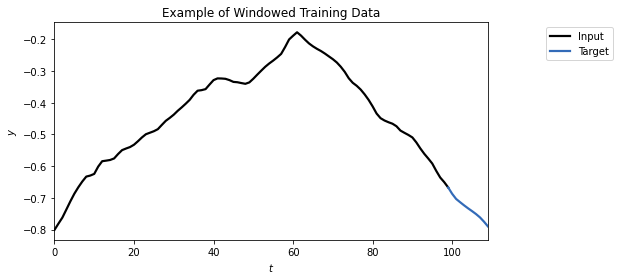

In [48]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), x_train[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[x_train[-1, 0, 0]], y_train[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

### Model Definition

#### Define LSTM Encoder and Decoder (Multistep Prediction)

In [49]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [50]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


#### Define Seq2Seq Model (Combining encoder and decoder)

In [51]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
    
    
    def val_metrics(self, input_tensor, target_tensor, batch_size=200, criterion=nn.MSELoss(), target_len=10):

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        val_batch_loss = 0.
        val_batch_mae = 0.
                
        for b in range(n_batches):
            input_batch = input_tensor[:, b: b + batch_size, :]
            target_batch = target_tensor[:, b: b + batch_size, :]

            # outputs tensor
            outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

            # initialize hidden state
            encoder_hidden = self.encoder.init_hidden(batch_size)
            encoder_output, encoder_hidden = self.encoder(input_batch)

            # decoder with teacher forcing
            decoder_input = input_batch[-1, :, :] 
            decoder_hidden = encoder_hidden

            for t in range(target_len): 
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                outputs[t] = decoder_output
                decoder_input = decoder_output

            # compute the loss 
            loss = criterion(outputs, target_batch)
            val_batch_loss += loss.item()
            
            # compute mae
            mae_func = nn.L1Loss()
            mae = mae_func(outputs, target_batch)
            val_batch_mae += mae.item()
        
        # loss for epoch 
        val_batch_loss /= n_batches 
        val_batch_mae /= n_batches
        
        return val_batch_loss, val_batch_mae
        
    
    def train_model(self, input_tensor, target_tensor, input_val, target_val, n_epochs, target_len,batch_size=200,learning_rate = 0.01, criterion = nn.MSELoss()):
        train_losses = np.full(n_epochs, np.nan)
        train_maes = np.full(n_epochs, np.nan)
        val_losses = np.full(n_epochs, np.nan)
        val_maes = np.full(n_epochs, np.nan)
        
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = criterion

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                train_batch_loss = 0.
                train_batch_mae = 0.
                #val_batch_loss = 0.
                #
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    train_batch_loss += loss.item()
                    
                    # mae
                    mae_func = nn.L1Loss()
                    mae = mae_func(outputs, target_batch)
                    train_batch_mae += mae.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()
                    
            
                # loss for epoch 
                train_batch_loss /= n_batches 
                train_batch_mae /= n_batches
                train_losses[it] = train_batch_loss
                train_maes[it] = train_batch_mae
                
                ### Compute validation metrics ###
                val_metrics = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)
                val_batch_mae = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)[1]
                valid_batch_loss = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)[0]
                val_losses[it] = valid_batch_loss
                val_maes[it] = val_batch_mae


                # progress bar 
                tr.set_postfix(validation_MSE="{0:.3f}".format(valid_batch_loss), training_MSE = "{0:.3f}".format(train_batch_loss))
                
                
        losses = {"Train":train_losses, "Val":val_losses, "Train_mae":train_maes, "Val_mae":val_maes}
        return losses
    

    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


#### Trained on 20 Epochs

In [52]:
mod = lstm_seq2seq(input_size=1, hidden_size=1)
losses = mod.train_model(train_dataset.x, train_dataset.y,\
                                                 valid_dataset.x, valid_dataset.y, \
                                                 n_epochs = 20, target_len = num_outputs,\
                                                 learning_rate = 0.0001,\
                                                 criterion = nn.MSELoss())

100%|██████████| 20/20 [00:11<00:00,  1.71it/s, training_MSE=1.689, validation_MSE=1.705]


In [53]:
losses

{'Train': array([1.96702992, 1.95439619, 1.94161713, 1.92868409, 1.9155867 ,
        1.90231562, 1.88886112, 1.87521255, 1.86135886, 1.84728567,
        1.83297601, 1.81840758, 1.80355397, 1.78838601, 1.77287532,
        1.75699511, 1.74072094, 1.72402901, 1.70689693, 1.68930565]),
 'Val': array([1.98618618, 1.97340374, 1.96047695, 1.94739389, 1.93414293,
        1.92071468, 1.90709814, 1.8932833 , 1.87925816, 1.86500783,
        1.85051408, 1.83575327, 1.82069794, 1.80531888, 1.78958834,
        1.7734797 , 1.75696882, 1.74003167, 1.72264732, 1.70479677]),
 'Train_mae': array([1.34711704, 1.3425235 , 1.33786212, 1.33312856, 1.32831799,
        1.32342591, 1.3184478 , 1.31337863, 1.30821325, 1.30294529,
        1.29756715, 1.29206926, 1.28644015, 1.28066695, 1.27473671,
        1.26863671, 1.26235482, 1.25587878, 1.24919677, 1.24230447]),
 'Val_mae': array([1.36051452, 1.35589789, 1.35121278, 1.34645384, 1.34161615,
        1.33669538, 1.33168633, 1.32658464, 1.3213843 , 1.31607865,
  

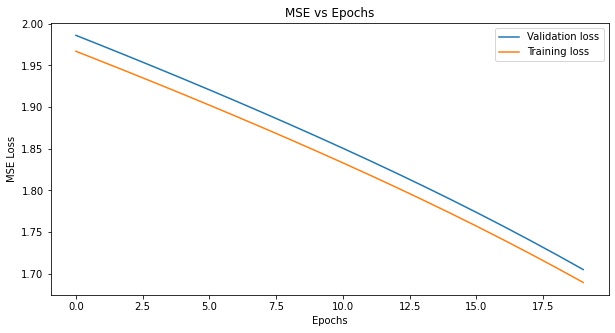

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses['Val'], label="Validation loss")
plt.plot(losses['Train'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MSE Loss")
plt.title("MSE vs Epochs")
plt.legend()
plt.show()

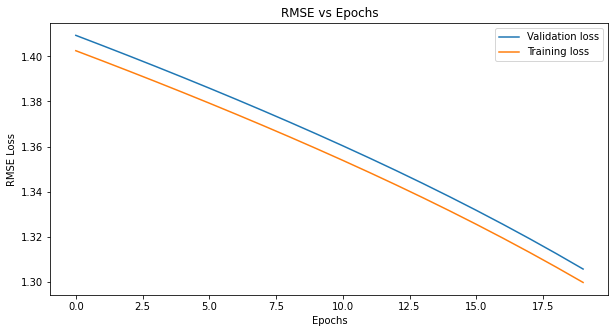

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(np.sqrt(losses['Val']), label="Validation loss")
plt.plot(np.sqrt(losses['Train']), label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("RMSE Loss")
plt.title("RMSE vs Epochs")
plt.legend()
plt.show()

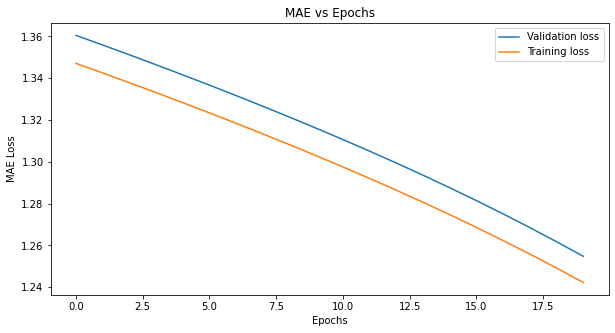

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses['Val_mae'], label="Validation loss")
plt.plot(losses['Train_mae'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MAE Loss")
plt.title("MAE vs Epochs")
plt.legend()
plt.show()

#### Trained on 100 Epochs

In [57]:
mod2 = lstm_seq2seq(input_size=1, hidden_size=1)
losses2 = mod2.train_model(train_dataset.x, train_dataset.y,\
                                                 valid_dataset.x, valid_dataset.y, \
                                                 n_epochs = 100, target_len = num_outputs,\
                                                 learning_rate = 0.0001,\
                                                 criterion = nn.MSELoss())

100%|██████████| 100/100 [00:54<00:00,  1.84it/s, training_MSE=0.183, validation_MSE=0.167]


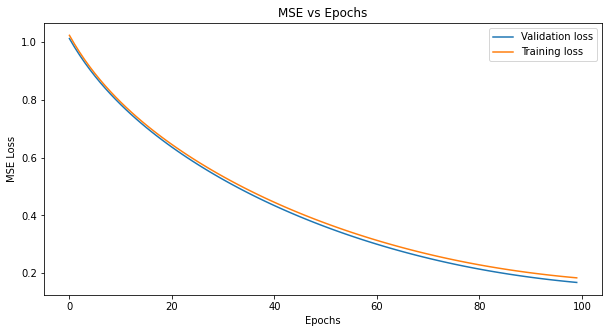

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses2['Val'], label="Validation loss")
plt.plot(losses2['Train'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MSE Loss")
plt.title("MSE vs Epochs")
plt.legend()
plt.show()

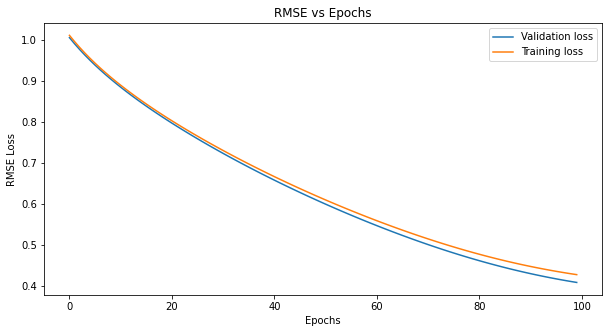

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(np.sqrt(losses2['Val']), label="Validation loss")
plt.plot(np.sqrt(losses2['Train']), label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("RMSE Loss")
plt.title("RMSE vs Epochs")
plt.legend()
plt.show()

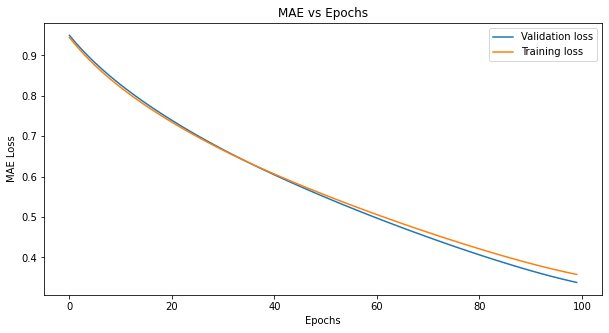

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses2['Val_mae'], label="Validation loss")
plt.plot(losses2['Train_mae'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MAE Loss")
plt.title("MAE vs Epochs")
plt.legend()
plt.show()

#### Trained on 300 Epochs

In [65]:
mod3 = lstm_seq2seq(input_size=1, hidden_size=1)
losses3 = mod3.train_model(train_dataset.x, train_dataset.y,\
                                                 valid_dataset.x, valid_dataset.y, \
                                                 n_epochs = 300, target_len = num_outputs,\
                                                 learning_rate = 0.0001,\
                                                 criterion = nn.MSELoss())

100%|██████████| 300/300 [02:56<00:00,  1.70it/s, training_MSE=0.034, validation_MSE=0.191]


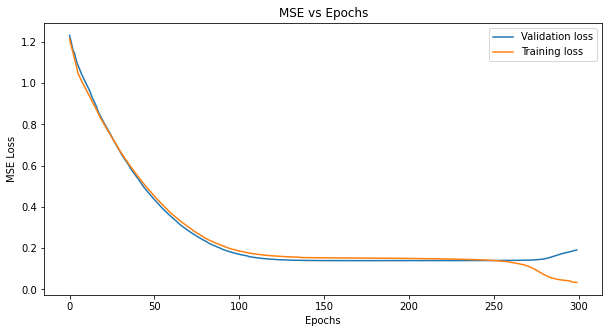

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses3['Val'], label="Validation loss")
plt.plot(losses3['Train'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MSE Loss")
plt.title("MSE vs Epochs")
plt.legend()
plt.show()

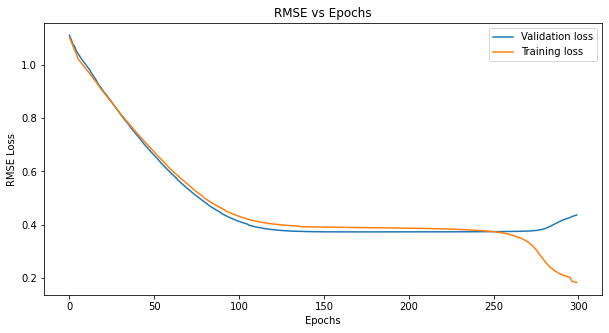

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(np.sqrt(losses3['Val']), label="Validation loss")
plt.plot(np.sqrt(losses3['Train']), label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("RMSE Loss")
plt.title("RMSE vs Epochs")
plt.legend()
plt.show()

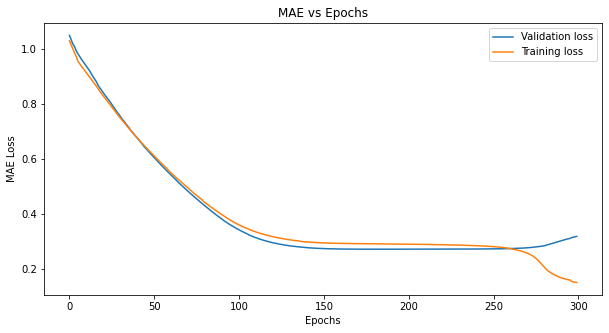

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(losses3['Val_mae'], label="Validation loss")
plt.plot(losses3['Train_mae'], label= "Training loss")
plt.xlabel('Epochs')
plt.ylabel("MAE Loss")
plt.title("MAE vs Epochs")
plt.legend()
plt.show()

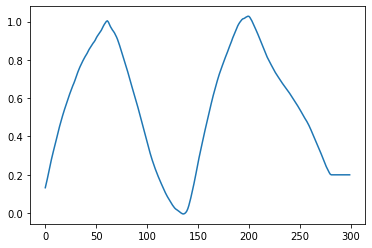

In [72]:
plt.plot(X_train[0])

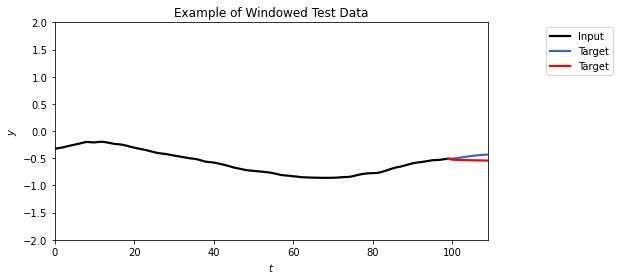

In [125]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), test_dataset.x[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 0, 0]], test_dataset.y[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')

y = mod3.predict(test_dataset.x[:,0], 10).reshape(-1)

plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 0, 0]], y]),
         color ='red', linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.ylim([-2, 2])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Test Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

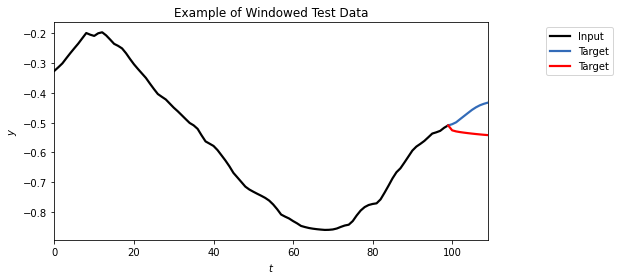

In [127]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), test_dataset.x[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 0, 0]], test_dataset.y[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')

y = mod3.predict(test_dataset.x[:,0], 10).reshape(-1)

plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 0, 0]], y]),
         color ='red', linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Test Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

In [134]:
test_dataset.y[:, 0, 0]

tensor([-0.5050, -0.4987, -0.4881, -0.4776, -0.4671, -0.4568, -0.4482, -0.4413,
        -0.4364, -0.4325])

In [135]:
 mod3.predict(test_dataset.x[:,0], 10).reshape(-1)


array([-0.525603  , -0.5292884 , -0.5315735 , -0.5334518 , -0.5351377 ,
       -0.53668284, -0.5381049 , -0.53941375, -0.54061764, -0.54172444],
      dtype=float32)

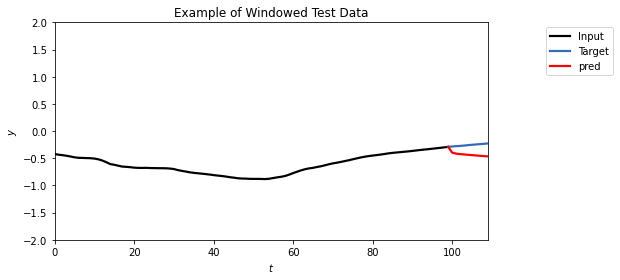

In [132]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), test_dataset.x[:, 45, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 45, 0]], test_dataset.y[:, 45, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')

y = mod3.predict(test_dataset.x[:,45], 10).reshape(-1)

plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 45, 0]], y]),
         color ='red', linewidth = 2.2, label = 'pred')
plt.xlim([0, iw + ow - 1])
plt.ylim([-2, 2])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Test Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

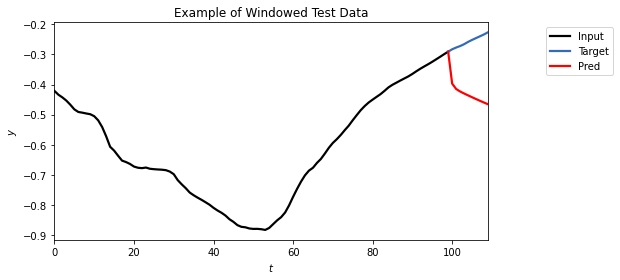

In [131]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), test_dataset.x[:, 45, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 45, 0]], test_dataset.y[:, 45, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')

y = mod3.predict(test_dataset.x[:,45], 10).reshape(-1)

plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[test_dataset.x[-1, 45, 0]], y]),
         color ='red', linewidth = 2.2, label = 'Pred')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Test Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

In [136]:
mod3.predict(test_dataset.x[:,45], 10).reshape(-1)

array([-0.3967973 , -0.4146108 , -0.42305994, -0.42970073, -0.43595988,
       -0.4420877 , -0.44811195, -0.45401913, -0.45978945, -0.46540308],
      dtype=float32)